# Structured Task

## Set up dependencies and data


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
%%bash
git clone https://github.com/omershubi/neural-complexity.git rnn
mkdir -p rnn/data/ptb

Cloning into 'rnn'...


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
GDRIVE_DIR = "/content/gdrive/My Drive/096222_project_surprisals_and_rts"
!mkdir -p "$GDRIVE_DIR"
!mkdir -p "$GDRIVE_DIR/corpus_data"

In [ ]:
!wget -qO rnn/data/ptb/ptb_tok_train.txt https://gist.githubusercontent.com/omershubi/cdd4231472d6188f03ab21e2b2729fee/raw/e1b4c764561fd038470830534baaa220b0eb4c6d/ptb_tok_train.txt
!wget -qO rnn/data/ptb/ptb_tok_dev.txt https://gist.githubusercontent.com/omershubi/31eff71b74dfb8cfe93d1a9acf8ab523/raw/094d3094b06beb92cd7fd0496710cf43273f8c64/ptb_tok_dev.txt
!cp rnn/data/ptb/* "$GDRIVE_DIR/corpus_data/"

## LSTM model

In [ ]:
!cd rnn && python main.py --cuda --model_file "$GDRIVE_DIR/ptb_model.pt" \
    --epochs 40 \
    --vocab_file "$GDRIVE_DIR/ptb_vocab.txt" \
    --tied --data_dir "$GDRIVE_DIR/corpus_data" --trainfname ptb_tok_train.txt --validfname ptb_tok_dev.txt

Libraries loaded
Traceback (most recent call last):
  File "/content/rnn/main.py", line 211, in <module>
    corpus = data.SentenceCorpus(args.data_dir, args.vocab_file, args.test, args.interact,
  File "/content/rnn/data.py", line 75, in __init__
    self.train = self.tokenize_with_unks(os.path.join(path, trainfname))
  File "/content/rnn/data.py", line 341, in tokenize_with_unks
    token += 1
KeyboardInterrupt
^C


In [ ]:
checkpoint_to_use = f"{GDRIVE_DIR}/ptb_model.pt"

In [ ]:
!cd rnn && python main.py --cuda --model_file "$checkpoint_to_use" \
    --vocab_file "$GDRIVE_DIR/ptb_vocab.txt" --data_dir './data' \
    --testfname 'brown.txt' --test --words --nopp > "$GDRIVE_DIR/rnn_surprisals.tsv"

Libraries loaded
Using beamsize: 23757


In [ ]:
import pandas as pd
lstm_surprisals = pd.read_csv(f'{GDRIVE_DIR}/rnn_surprisals.tsv',sep=' ')
lstm_surprisals

,word,sentid,sentpos,wlen,surp,entropy,entred
0,In,0,0,2,5.506053,9.515585,0.000000
1,<unk>,0,1,5,6.578504,7.866125,1.649460
2,County,0,2,6,12.514248,6.056062,1.810063
3,<unk>,0,3,5,7.031470,8.524199,0.000000
4,near,0,4,4,13.308077,8.640187,0.000000
...,...,...,...,...,...,...,...
7229,as,363,15,2,6.248776,4.505761,3.256542
7230,a,363,16,1,2.861911,7.777086,0.000000
7231,leader,363,17,6,11.365563,11.206182,0.000000
7232,and,363,18,3,6.632089,5.544580,5.661602


In [ ]:
sprt = pd.read_csv('https://gist.githubusercontent.com/omershubi/01b55eab89b81dc882055e0d27d61016/raw/046dbb7f0586b5dc1a368ee882f2cb923caad3df/brown-spr-data-for-pset.csv', index_col=0).sort_values(by='code')
sprt

,word,code,subject,text_id,text_pos,word_in_exp,time
2286,In,17000,s001,0,0,2285,399.90
109460,In,17000,s028,0,0,2503,290.32
50709,In,17000,s014,0,0,1394,501.59
80486,In,17000,s021,0,0,2525,210.93
35626,In,17000,s010,0,0,579,862.35
...,...,...,...,...,...,...,...
79391,captain.,35763,s021,12,763,1430,425.18
116505,captain.,35763,s030,12,763,1489,383.32
26975,captain.,35763,s007,12,763,3426,506.40
15206,captain.,35763,s004,12,763,3528,669.29


In [ ]:
def get_spillover(data: pd.DataFrame, column_to_shift: str, column_to_reference: str, new_name: str  = "spill_over") -> None:
    nn_unk = new_name+'_inc_unk'
    data[new_name] = [val if ref != '<unk>' else np.nan for val, ref in data[[column_to_shift, column_to_reference]].values]
    data[nn_unk] =  [val for val in data[column_to_shift].values]
    data[nn_unk] = data[nn_unk].shift(periods=-1)
    data[new_name] = data[new_name].shift(periods=-1)

In [ ]:
def harmonize(rt_data: pd.DataFrame, surprs_data: pd.DataFrame, spillover: bool) -> pd.DataFrame:
    unique = rt_data.drop(['subject', 'time', 'word_in_exp'], axis=1).copy() # Get just the word and the code.
    unique.drop_duplicates(['code'], inplace=True) # Get the unique values
    unique = unique.reset_index()
    remove_punc = surprs_data[~surprs_data['word'].isin(['</s>', '--'])].reset_index()
    remove_punc = remove_punc.drop(index=[3457,4453,4472], axis=0).reset_index()
    remove_punc = remove_punc.rename(columns={'word': 'token'})
    code_supr = pd.concat([unique, remove_punc],axis=1)[['code', 'surp', 'token']] # The data has now been aligned.

    mean_sprt = sprt.groupby(['code', 'word']).mean().rename(columns={'time': 'mean_rt'})
    final = code_supr.merge(mean_sprt, on='code')
    if spillover:
        get_spillover(final, 'mean_rt', 'token', 'rt_spill_over')
    final = final[final['token']!='<unk>']
    final = final[['code', 'token', 'surp', 'mean_rt', 'rt_spill_over', 'rt_spill_over_inc_unk']]
    return final

In [ ]:
harmonized_lstm = harmonize(sprt, lstm_surprisals, spillover=True)
harmonized_lstm.to_csv("harmonized_lstm.csv", index=False)

<ipython-input-11-e939be7fe708>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_sprt = sprt.groupby(['code', 'word']).mean().rename(columns={'time': 'mean_rt'})


## Comparing N-gram and RNN

### 1.  Correlation with reading times

In [ ]:
harmonized_ngram = pd.read_csv('harmonized_ngram.csv')
harmonized_ngram
harmonized_lstm = pd.read_csv('harmonized_lstm.csv')

print(len(harmonized_lstm), len(harmonized_ngram))

harmonized_ngram = harmonized_ngram.rename(columns={'surprisal': 'ngram_surp'})
harmonized_lstm = harmonized_lstm.rename(columns={'surp': 'lstm_surp'})

data = pd.concat([harmonized_lstm, harmonized_ngram['ngram_surp']], axis=1)
data

5500 5500


,code,token,lstm_surp,mean_rt,entropy,entred,rt_spill_over,rt_spill_over_inc_unk,ngram_surp
0,17000,In,5.506053,380.275294,9.515585,0.000000,NaN,335.850588,4.57937
1,17002,County,12.514248,296.042941,6.056062,1.810063,NaN,481.850000,12.65410
2,17004,near,13.308077,403.553529,8.640187,0.000000,306.075882,306.075882,12.22380
3,17005,the,1.662673,306.075882,7.870934,0.769253,289.048235,289.048235,1.98095
4,17006,River,17.830992,289.048235,11.037002,0.000000,NaN,321.790588,15.70900
...,...,...,...,...,...,...,...,...,...
5495,35758,failed,9.048445,292.772500,7.762303,0.462083,284.470833,284.470833,8.25341
5496,35759,as,6.248776,284.470833,4.505761,3.256542,282.622083,282.622083,9.42416
5497,35760,a,2.861911,282.622083,7.777086,0.000000,279.445417,279.445417,3.23962
5498,35761,leader,11.365563,279.445417,11.206182,0.000000,299.705000,299.705000,12.81650


In [ ]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt

WITH_CONSTANT = False


X = data[['lstm_surp', 'ngram_surp']]
y = data['mean_rt']

if WITH_CONSTANT:
    X = sm.add_constant(X)
model = sm.OLS(y, X)
res = model.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                mean_rt   R-squared (uncentered):                   0.812
Model:                            OLS   Adj. R-squared (uncentered):              0.812
Method:                 Least Squares   F-statistic:                          1.188e+04
Date:                Thu, 29 Jun 2023   Prob (F-statistic):                        0.00
Time:                        11:26:57   Log-Likelihood:                         -34835.
No. Observations:                5500   AIC:                                  6.967e+04
Df Residuals:                    5498   BIC:                                  6.969e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

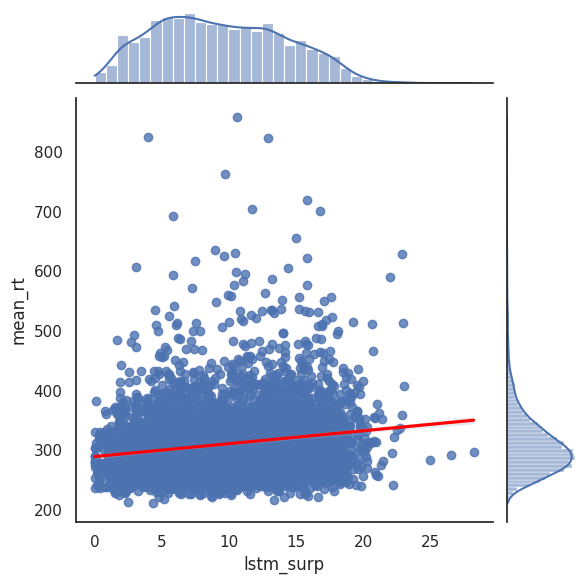

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="white", color_codes=True)

g = sns.jointplot(x="lstm_surp", y="mean_rt", data=data, kind='reg')
# We're going to make the regression line red so it's easier to see
regline = g.ax_joint.get_lines()[0]
regline.set_color('red')

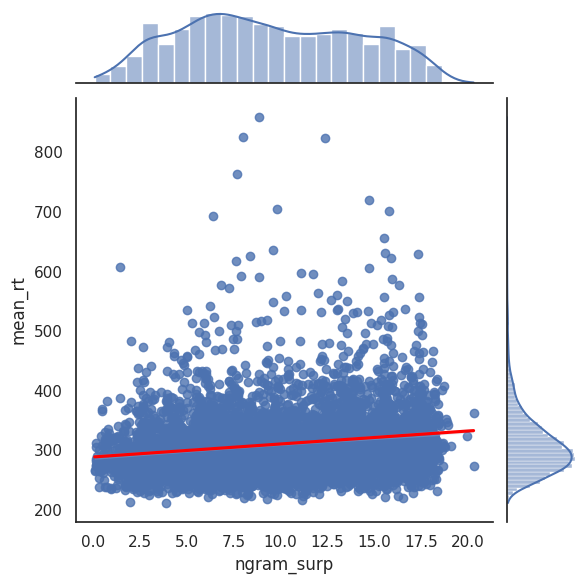

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="white", color_codes=True)

g = sns.jointplot(x="ngram_surp", y="mean_rt", data=data, kind='reg')
# We're going to make the regression line red so it's easier to see
regline = g.ax_joint.get_lines()[0]
regline.set_color('red')

In [ ]:
data[['lstm_surp', 'ngram_surp', 'mean_rt']].corr()

,lstm_surp,ngram_surp,mean_rt
lstm_surp,1.000000,0.894903,0.189204
ngram_surp,0.894903,1.000000,0.182612
mean_rt,0.189204,0.182612,1.000000


### 2.  Plots

/usr/local/lib/python3.10/dist-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


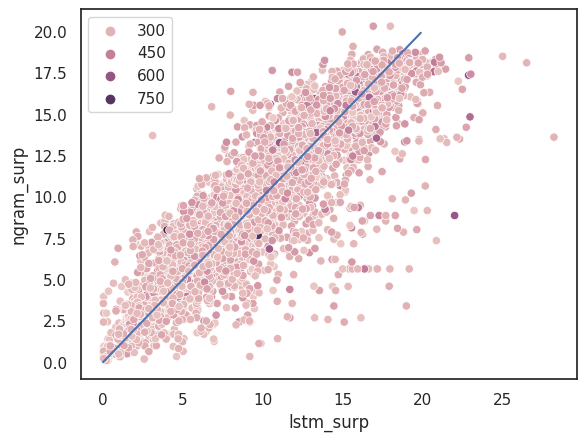

In [ ]:
import seaborn as sns

sns.scatterplot(data=data, x='lstm_surp', y='ngram_surp', hue='mean_rt', cmap='RdBu')
sns.lineplot(x=np.arange(0, 20, 0.1), y=np.arange(0, 20, 0.1))
plt.show()

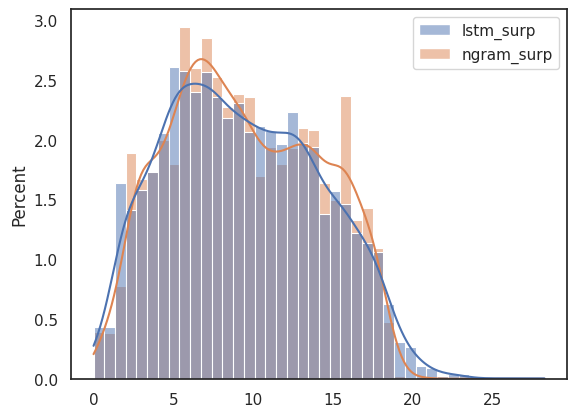

In [ ]:
 sns.histplot(data=data[['lstm_surp', 'ngram_surp']], stat='percent', kde=True)
 plt.show()

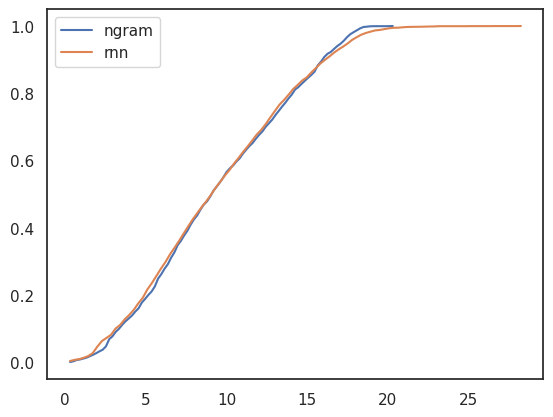

In [ ]:
count, bins_count = np.histogram(data['ngram_surp'], bins=100)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], cdf, label="ngram")
plt.legend()

count, bins_count = np.histogram(data['lstm_surp'], bins=100)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], cdf, label="rnn")
plt.legend()

plt.show()

### 3. Interesting Points

In [ ]:
data['diff'] = abs(data['lstm_surp'] - data['ngram_surp'])

<Axes: xlabel='diff', ylabel='Percent'>

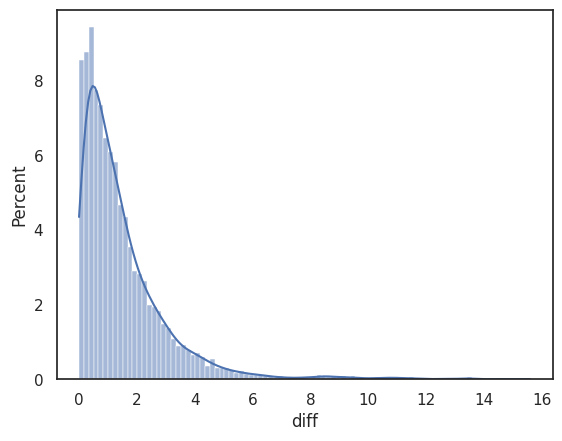

In [ ]:
 sns.histplot(data, x='diff', stat='percent', kde=True)

In [ ]:
data['diff'].describe()

count    5500.000000
mean        1.489107
std         1.569271
min         0.000467
25%         0.474076
50%         1.050598
75%         1.962697
max        15.596337
Name: diff, dtype: float64

In [ ]:
th = data['diff'].mean() + 3 * data['diff'].std()
large_diff = data[data['diff'] > th]
large_diff

,code,token,lstm_surp,mean_rt,entropy,entred,rt_spill_over,rt_spill_over_inc_unk,ngram_surp,diff
84,17112,Today,19.301353,355.517647,5.842750,0.479889,274.722353,274.722353,10.21250,9.088853
88,17116,may,18.108437,291.488235,3.875476,1.665796,293.771765,293.771765,9.87549,8.232947
96,17127,corps,15.566020,443.555294,9.101665,0.000000,321.235294,321.235294,8.12025,7.445770
140,17186,eyes,14.340526,346.834706,10.482044,0.000000,285.054706,285.054706,6.21132,8.129206
156,17209,first,20.191124,331.524118,5.520196,3.432480,278.855294,278.855294,12.24010,7.951024
...,...,...,...,...,...,...,...,...,...,...
5350,35566,South,10.930376,294.574583,10.902568,0.000000,NaN,316.819167,1.42276,9.507616
5368,35587,had,18.934946,294.281667,7.878981,0.000000,292.414167,292.414167,9.80080,9.134146
5394,35626,Davis,9.152434,297.197917,8.920102,0.000000,306.877500,306.877500,15.58080,6.428366
5413,35652,He,17.176094,296.628750,8.123198,1.306364,296.315833,296.315833,5.63280,11.543294


### 4. Spilover

In [ ]:
spill_over_data['prob'] = [1 / np.exp(s) for s in spill_over_date.ngram_surp]

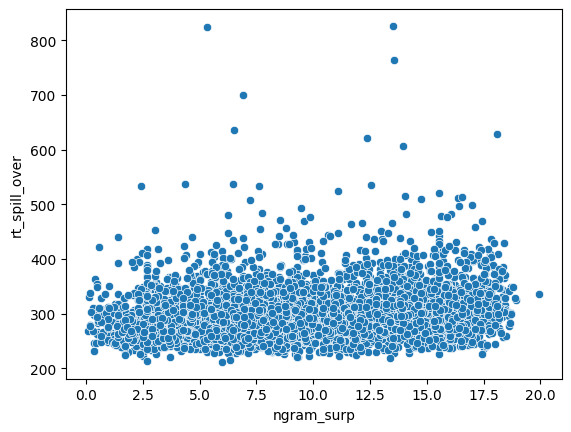

In [ ]:
sns.scatterplot(data=spill_over_data, x='ngram_surp', y='rt_spill_over')
plt.show()

In [ ]:
spill_over_data = data[['ngram_surp', 'lstm_surp','mean_rt', 'rt_spill_over', 'rt_spill_over_inc_unk']]
spill_over_data

,ngram_surp,lstm_surp,mean_rt,rt_spill_over,rt_spill_over_inc_unk
0,4.57937,5.506053,380.275294,NaN,335.850588
1,12.65410,12.514248,296.042941,NaN,481.850000
2,12.22380,13.308077,403.553529,306.075882,306.075882
3,1.98095,1.662673,306.075882,289.048235,289.048235
4,15.70900,17.830992,289.048235,NaN,321.790588
...,...,...,...,...,...
5495,8.25341,9.048445,292.772500,284.470833,284.470833
5496,9.42416,6.248776,284.470833,282.622083,282.622083
5497,3.23962,2.861911,282.622083,279.445417,279.445417
5498,12.81650,11.365563,279.445417,299.705000,299.705000


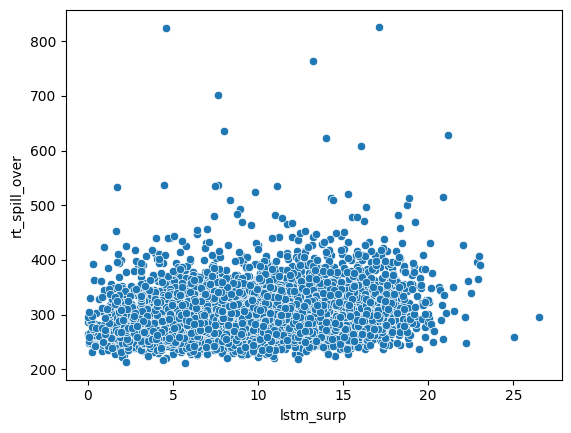

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# RNN Surprisals - no unk spill over
sns.scatterplot(data=spill_over_data, x='lstm_surp', y='rt_spill_over')
plt.show()

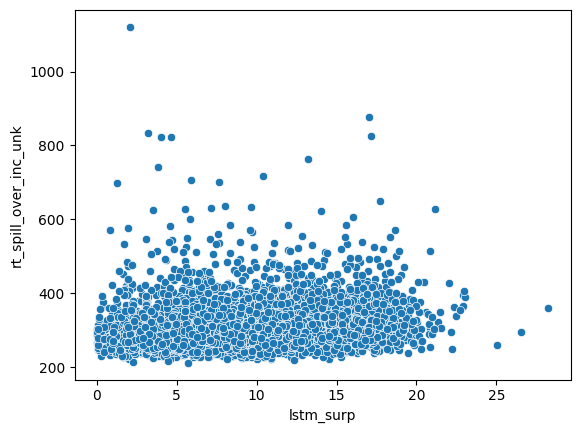

In [ ]:
# RNN Surprisals - unsing unk spill over
sns.scatterplot(data=spill_over_data, x='lstm_surp', y='rt_spill_over_inc_unk')
plt.show()

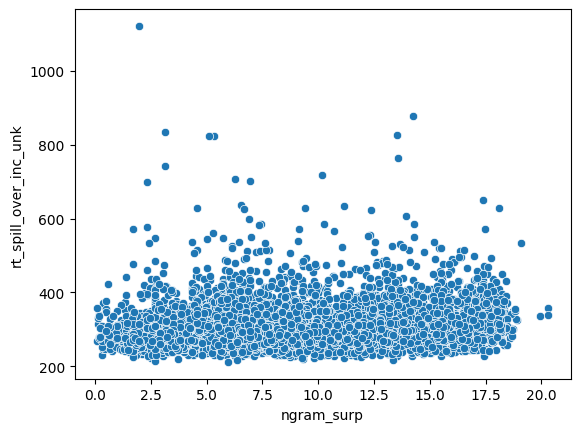

In [ ]:
# n=gram Surprisals - using unk spillover
sns.scatterplot(data=spill_over_data, x='ngram_surp', y='rt_spill_over_inc_unk')
plt.show()

In [ ]:
spill_over_data.corr()

,ngram_surp,lstm_surp,mean_rt,rt_spill_over,rt_spill_over_inc_unk
ngram_surp,1.000000,0.894903,0.182612,0.177000,0.121358
lstm_surp,0.894903,1.000000,0.189204,0.188504,0.129006
mean_rt,0.182612,0.189204,1.000000,0.464907,0.396850
rt_spill_over,0.177000,0.188504,0.464907,1.000000,1.000000
rt_spill_over_inc_unk,0.121358,0.129006,0.396850,1.000000,1.000000


# Semi-Structured Task

## 1. GAM

In [ ]:
from pandas.io.formats.style_render import DefaultDict
###TODO: your code here
def counts_from_text(text):
  word_counts = DefaultDict(int)
  with open(text, 'r') as f:
    for sentence in f.readlines():
      for word in sentence.split(' '):
        word_counts[word] = word_counts.get(word , 0) + 1
  df = pd.DataFrame.from_dict(word_counts, orient='index', columns=['count']).reset_index()
  df.columns = ['token', 'count']
  df['log_freq'] = [np.log10(count) for count in df['count']]
  return df

#calculate log frequencies and add the information as a new column in␣
word_count_df = counts_from_text('rnn/data/ptb/ptb_tok_train.txt')
merged = data.merge(word_count_df, on='token').sort_values('code').reset_index()
merged['len'] = [len(t) for t in merged['token']]
merged.head()

FileNotFoundError: ignored

In [ ]:
!pip install pygam

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s, f

In [ ]:
import pandas as pd
merged = pd.read_csv('full_data.csv')

In [ ]:
X = merged[['lstm_surp', 'ngram_surp', 'len', 'log_freq']].to_numpy()
y = merged['mean_rt'].to_numpy()

100% (11 of 11) |########################| Elapsed Time: 0:00:05 Time:  0:00:05


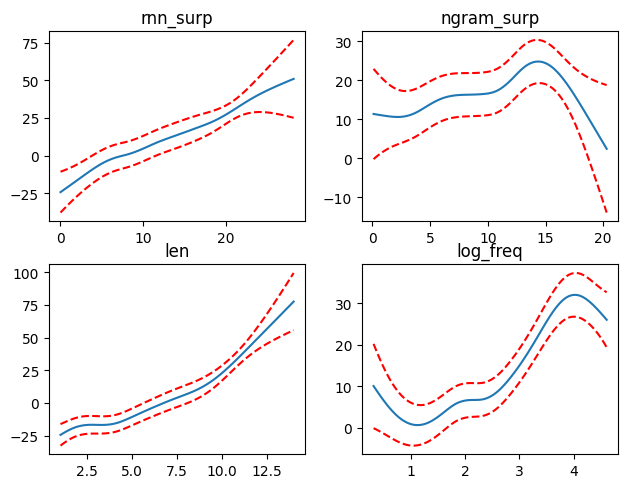

In [ ]:
gam = LinearGAM()
gam.gridsearch(X, y)

fig, axs = plt.subplots(2, 2);
fig.tight_layout(pad=1.0)

idx = [[0, 0], [0, 1], [1, 0], [1, 1]]
titles = ['rnn_surp', 'ngram_surp', 'len', 'log_freq']
for i in range(len(idx)):
  ax = axs[idx[i][0], idx[i][1]]
  XX = gam.generate_X_grid(term=i)
  ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
  ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
  ax.set_title(titles[i])

In [ ]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     21.4927
Link Function:                     IdentityLink Log Likelihood:                                -48713.0394
Number of Samples:                         5500 AIC:                                            97471.0643
                                                AICc:                                           97471.2573
                                                GCV:                                             2821.0263
                                                Scale:                                           2801.1902
                                                Pseudo R-Squared:                                   0.0721
Feature Function                  Lam

<ipython-input-43-dec6a6acdaaa>:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [ ]:
y_so = merged['rt_spill_over_inc_unk'].to_numpy()

100% (11 of 11) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


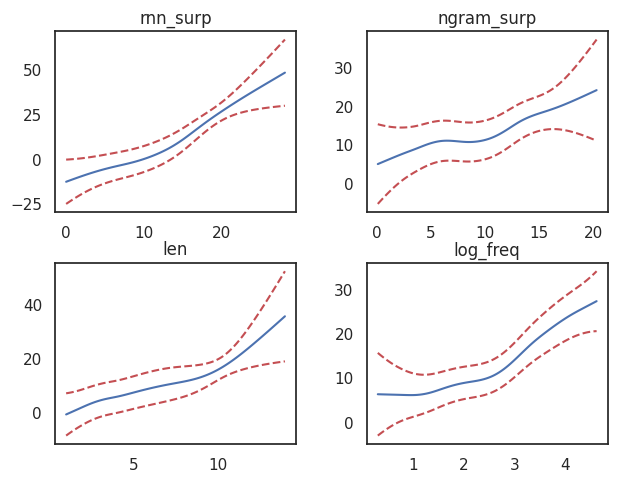

In [ ]:
gam = LinearGAM()
gam.gridsearch(X, y_so)

fig, axs = plt.subplots(2, 2);
fig.tight_layout(pad=1.0)

idx = [[0, 0], [0, 1], [1, 0], [1, 1]]
titles = ['rnn_surp', 'ngram_surp', 'len', 'log_freq']
for i in range(len(idx)):
  ax = axs[idx[i][0], idx[i][1]]
  XX = gam.generate_X_grid(term=i)
  ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
  ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
  ax.set_title(titles[i])

In [ ]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     15.5001
Link Function:                     IdentityLink Log Likelihood:                                -49582.2409
Number of Samples:                         5500 AIC:                                            99197.4821
                                                AICc:                                           99197.5874
                                                GCV:                                               3297.59
                                                Scale:                                           3280.8663
                                                Pseudo R-Squared:                                   0.0285
Feature Function                  Lam

<ipython-input-46-dec6a6acdaaa>:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


## 2.  Larger Dataset: Wikitext-2

In [ ]:
ngram_wiki_surp = pd.read_csv('/content/brown_surp_wiki2_ngram.tsv', sep='\t')
harmonized_wiki_ngram = harmonize(sprt, ngram_wiki_surp, spillover=True)
harmonized_wiki_ngram

<ipython-input-168-d809dadd3da6>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_sprt = sprt.groupby(['code', 'word']).mean().rename(columns={'time': 'mean_rt'})


,code,token,surp,mean_rt,rt_spill_over,rt_spill_over_inc_unk
0,17000,In,4.843203,380.275294,335.850588,335.850588
1,17001,Ireland's,9.216198,335.850588,296.042941,296.042941
2,17002,County,7.342722,296.042941,481.850000,481.850000
3,17003,"Limerick,",9.216198,481.850000,403.553529,403.553529
4,17004,near,7.400831,403.553529,306.075882,306.075882
...,...,...,...,...,...,...
7183,35759,as,6.107614,284.470833,282.622083,282.622083
7184,35760,a,6.615626,282.622083,279.445417,279.445417
7185,35761,leader,8.109739,279.445417,299.705000,299.705000
7186,35762,and,5.774643,299.705000,381.612083,381.612083


In [ ]:
rnn_wiki_surp = pd.read_csv('/content/wiki2_rnn_surprisals.tsv', sep=' ')
harmonized_wiki_rnn = harmonize(sprt, rnn_wiki_surp, spillover=True)
harmonized_wiki_rnn

<ipython-input-11-e939be7fe708>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_sprt = sprt.groupby(['code', 'word']).mean().rename(columns={'time': 'mean_rt'})


,code,token,surp,mean_rt,entropy,entred,rt_spill_over,rt_spill_over_inc_unk
0,17000,In,6.475119,380.275294,11.105680,0.000000,NaN,335.850588
2,17002,County,11.517129,296.042941,7.625983,1.516422,NaN,481.850000
4,17004,near,10.847681,403.553529,7.662211,0.000000,306.075882,306.075882
5,17005,the,1.980971,306.075882,8.989469,0.000000,289.048235,289.048235
6,17006,River,12.027287,289.048235,11.646304,0.000000,NaN,321.790588
...,...,...,...,...,...,...,...,...
7182,35758,failed,10.059935,292.772500,9.331731,0.000000,284.470833,284.470833
7183,35759,as,6.448711,284.470833,8.436277,0.895453,282.622083,282.622083
7184,35760,a,2.876720,282.622083,8.531895,0.000000,279.445417,279.445417
7185,35761,leader,12.023465,279.445417,11.574893,0.000000,299.705000,299.705000


In [ ]:
harmonized_wiki_ngram = harmonized_wiki_ngram.rename(columns={'surp': 'ngram_surp'})
harmonized_wiki_rnn = harmonized_wiki_rnn.rename(columns={'surp': 'lstm_surp'})


print(len(harmonized_wiki_ngram), len(harmonized_wiki_rnn))


data_wiki = pd.merge(harmonized_wiki_rnn, harmonized_wiki_ngram, on='code')
data_wiki

7188 5647


,code,token_x,lstm_surp,mean_rt_x,entropy,entred,rt_spill_over_x,rt_spill_over_inc_unk_x,token_y,ngram_surp,mean_rt_y,rt_spill_over_y,rt_spill_over_inc_unk_y
0,17000,In,6.475119,380.275294,11.105680,0.000000,NaN,335.850588,In,4.843203,380.275294,335.850588,335.850588
1,17002,County,11.517129,296.042941,7.625983,1.516422,NaN,481.850000,County,7.342722,296.042941,481.850000,481.850000
2,17004,near,10.847681,403.553529,7.662211,0.000000,306.075882,306.075882,near,7.400831,403.553529,306.075882,306.075882
3,17005,the,1.980971,306.075882,8.989469,0.000000,289.048235,289.048235,the,6.279943,306.075882,289.048235,289.048235
4,17006,River,12.027287,289.048235,11.646304,0.000000,NaN,321.790588,River,5.324226,289.048235,321.790588,321.790588
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5642,35758,failed,10.059935,292.772500,9.331731,0.000000,284.470833,284.470833,failed,8.089022,292.772500,284.470833,284.470833
5643,35759,as,6.448711,284.470833,8.436277,0.895453,282.622083,282.622083,as,6.107614,284.470833,282.622083,282.622083
5644,35760,a,2.876720,282.622083,8.531895,0.000000,279.445417,279.445417,a,6.615626,282.622083,279.445417,279.445417
5645,35761,leader,12.023465,279.445417,11.574893,0.000000,299.705000,299.705000,leader,8.109739,279.445417,299.705000,299.705000


In [ ]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt

WITH_CONSTANT = False


X = data_wiki[['lstm_surp', 'ngram_surp']]
y = data_wiki['mean_rt_y']

if WITH_CONSTANT:
    X = sm.add_constant(X)
model = sm.OLS(y, X)
res = model.fit()
print(res.summary())


                                 OLS Regression Results                                
Dep. Variable:              mean_rt_y   R-squared (uncentered):                   0.959
Model:                            OLS   Adj. R-squared (uncentered):              0.959
Method:                 Least Squares   F-statistic:                          6.525e+04
Date:                Thu, 29 Jun 2023   Prob (F-statistic):                        0.00
Time:                        14:29:03   Log-Likelihood:                         -31513.
No. Observations:                5647   AIC:                                  6.303e+04
Df Residuals:                    5645   BIC:                                  6.304e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

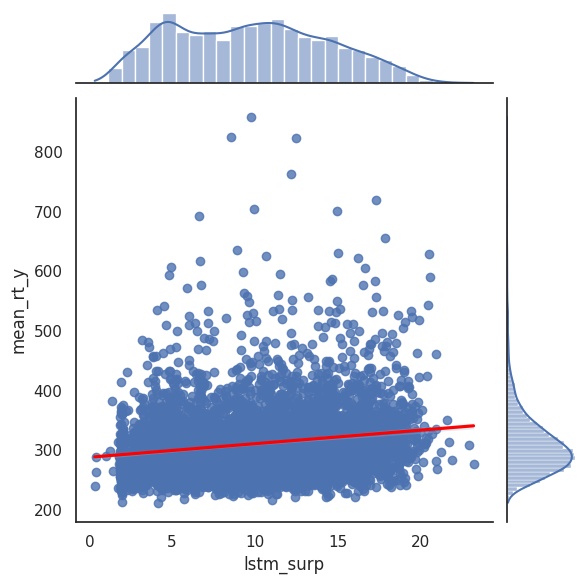

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="white", color_codes=True)

g = sns.jointplot(x="lstm_surp", y="mean_rt_y", data=data_wiki, kind='reg')
# We're going to make the regression line red so it's easier to see
regline = g.ax_joint.get_lines()[0]
regline.set_color('red')

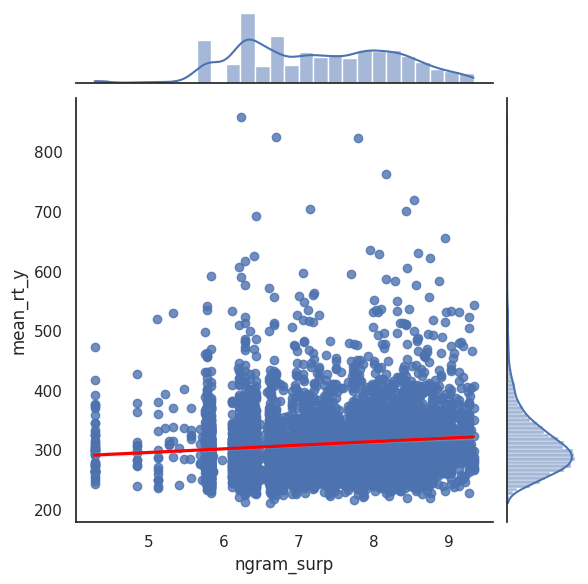

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="white", color_codes=True)

g = sns.jointplot(x="ngram_surp", y="mean_rt_y", data=data_wiki, kind='reg')
# We're going to make the regression line red so it's easier to see
regline = g.ax_joint.get_lines()[0]
regline.set_color('red')

/usr/local/lib/python3.10/dist-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


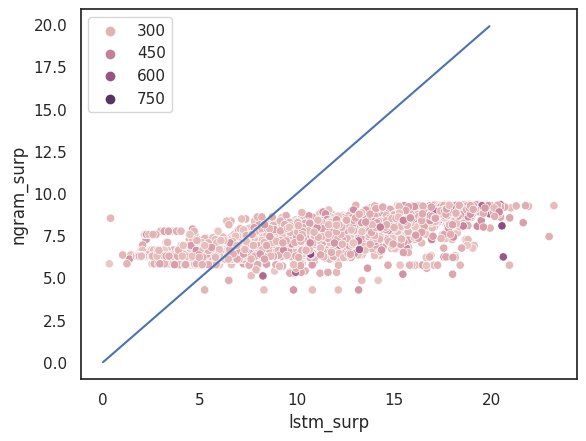

In [ ]:
import seaborn as sns

sns.scatterplot(data=data_wiki, x='lstm_surp', y='ngram_surp', hue='mean_rt_x', cmap='RdBu')
sns.lineplot(x=np.arange(0, 20, 0.1), y=np.arange(0, 20, 0.1))
plt.show()

In [ ]:
data_wiki[['lstm_surp', 'ngram_surp', 'mean_rt_y']].corr()

,lstm_surp,ngram_surp,mean_rt_y
lstm_surp,1.000000,0.801884,0.189531
ngram_surp,0.801884,1.000000,0.111560
mean_rt_y,0.189531,0.111560,1.000000


#Open-Ended Task

## Training Other Models

### GRU

In [ ]:
!cd rnn && python main.py --cuda --model_file "$GDRIVE_DIR/ptb_model_gru.pt" \
    --model 'GRU' \
    --epochs 40 \
    --vocab_file "$GDRIVE_DIR/ptb_vocab.txt" \
    --tied --data_dir "$GDRIVE_DIR/corpus_data" \
    --trainfname ptb_tok_train.txt \
    --validfname ptb_tok_dev.txt

Libraries loaded
| epoch   1 |   200/ 1422 batches | lr 20.00 | ms/batch 15.27 | loss 35.83 | ppl 3628487719019468.50
| epoch   1 |   400/ 1422 batches | lr 20.00 | ms/batch 11.17 | loss 38.65 | ppl 61073838168182408.00
| epoch   1 |   600/ 1422 batches | lr 20.00 | ms/batch 11.17 | loss 26.23 | ppl 247388152342.78
| epoch   1 |   800/ 1422 batches | lr 20.00 | ms/batch 11.21 | loss 24.75 | ppl 56331970420.88
| epoch   1 |  1000/ 1422 batches | lr 20.00 | ms/batch 11.27 | loss 25.86 | ppl 169655340547.48
| epoch   1 |  1200/ 1422 batches | lr 20.00 | ms/batch 11.42 | loss 28.54 | ppl 2472135686866.66
| epoch   1 |  1400/ 1422 batches | lr 20.00 | ms/batch 11.33 | loss 32.57 | ppl 139412016631048.83
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 17.01s | lr: 20.00000000 | valid ppl 974014541133494.62
-----------------------------------------------------------------------------------------
| epoch   2 |   200/ 1422 bat

In [ ]:
gru_checkpoint_to_use = f"{GDRIVE_DIR}/ptb_model_gru.pt"

In [ ]:
!cd rnn && python main.py --cuda --model_file "$gru_checkpoint_to_use" \
    --vocab_file "$GDRIVE_DIR/ptb_vocab.txt" --data_dir './data' \
    --testfname 'brown.txt' --test --words --nopp > "$GDRIVE_DIR/gru_surprisals.tsv"

Libraries loaded
Using beamsize: 23757


In [ ]:
import pandas as pd
gru_surprisals = pd.read_csv(f'{GDRIVE_DIR}/gru_surprisals.tsv',sep=' ')
gru_surprisals

,word,sentid,sentpos,wlen,surp,entropy,entred
0,In,0,0,2,19.886150,0.860207,0.000000
1,<unk>,0,1,5,5.104656,8.123015,0.000000
2,County,0,2,6,31.107187,5.916144,2.206872
3,<unk>,0,3,5,8.487823,5.948277,0.000000
4,near,0,4,4,27.882982,5.947841,0.000436
...,...,...,...,...,...,...,...
7229,as,363,15,2,22.735083,4.370323,0.000000
7230,a,363,16,1,1.077791,4.372886,0.000000
7231,leader,363,17,6,29.849722,4.370471,0.002415
7232,and,363,18,3,10.087594,4.468485,0.000000


### RNN with Tann

In [ ]:
!cd rnn && python main.py --cuda --model_file "$GDRIVE_DIR/ptb_model_rnn_tanh.pt" \
    --model 'RNN_TANH' \
    --epochs 40 \
    --vocab_file "$GDRIVE_DIR/ptb_vocab.txt" \
    --tied --data_dir "$GDRIVE_DIR/corpus_data" \
    --trainfname ptb_tok_train.txt \
    --validfname ptb_tok_dev.txt

In [ ]:
tanh_checkpoint_to_use = f"{GDRIVE_DIR}/ptb_model_rnn_tanh.pt"

In [ ]:
import pandas as pd
tanh_surprisals = pd.read_csv(f'{GDRIVE_DIR}/tanh_surprisals.tsv',sep=' ')
tanh_surprisals

,word,sentid,sentpos,wlen,surp,entropy,entred
0,In,0,0,2,9.196772,10.204051,0.000000
1,<unk>,0,1,5,5.647822,10.123851,0.080200
2,County,0,2,6,14.011380,9.489484,0.634367
3,<unk>,0,3,5,5.535500,9.489357,0.000127
4,near,0,4,4,13.445121,9.489357,0.000000
...,...,...,...,...,...,...,...
7229,as,363,15,2,7.971673,9.489357,0.000000
7230,a,363,16,1,5.707079,9.489357,0.000000
7231,leader,363,17,6,13.818408,9.489357,0.000000
7232,and,363,18,3,5.797373,9.489357,0.000000


### Harmonize Data

In [ ]:
harmonized_gru = harmonize(sprt, gru_surprisals, spillover=True)
harmonized_gru.to_csv("harmonized_gru.csv", index=False)

harmonized_rnn_tanh = harmonize(sprt, tanh_surprisals, spillover=True)
harmonized_rnn_tanh.to_csv("harmonized_rnn_tanh.csv", index=False)

<ipython-input-11-e939be7fe708>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_sprt = sprt.groupby(['code', 'word']).mean().rename(columns={'time': 'mean_rt'})
<ipython-input-11-e939be7fe708>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_sprt = sprt.groupby(['code', 'word']).mean().rename(columns={'time': 'mean_rt'})


## Analysis

In [ ]:
import pandas as pd

harmonized_ngram = pd.read_csv('harmonized_ngram.csv')
harmonized_lstm = pd.read_csv('harmonized_lstm.csv')
harmonized_gru = pd.read_csv('harmonized_gru.csv')
harmonized_rnn_tanh = pd.read_csv('harmonized_rnn_tanh.csv')

harmonized_ngram = harmonized_ngram.rename(columns={'surprisal': 'ngram_surp'})
harmonized_lstm = harmonized_lstm.rename(columns={'surp': 'lstm_surp'})
harmonized_gru = harmonized_gru.rename(columns={'surp': 'gru_surp'})
harmonized_rnn_tanh = harmonized_rnn_tanh.rename(columns={'surp': 'tanh_surp'})


data = pd.concat([harmonized_lstm, harmonized_ngram['ngram_surp'],
                  harmonized_gru['gru_surp'],
                  harmonized_rnn_tanh['tanh_surp']], axis=1)
data

FileNotFoundError: ignored

In [ ]:
word_count_df = counts_from_text('rnn/data/ptb/ptb_tok_train.txt')
merged = data.merge(word_count_df, on='token').sort_values('code').reset_index()
merged['len'] = [len(t) for t in merged['token']]
merged.head()

merged.to_csv("full_data.csv", index=False)

NameError: ignored

### Predicting Reading Time

In [ ]:
import pandas as pd
import numpy as np
ml_data = pd.read_csv('full_data.csv')
ml_data.replace([np.inf, -np.inf], np.nan, inplace=True)
ml_data.dropna(inplace=True)
ml_data.head()

,index,code,token,lstm_surp,mean_rt,entropy,entred,rt_spill_over,rt_spill_over_inc_unk,ngram_surp,gru_surp,tanh_surp,count,log_freq,len
2,14,17004,near,13.308077,403.553529,8.640187,0.000000,306.075882,306.075882,12.22380,27.882982,13.445121,109,2.037426,4
3,21,17005,the,1.662673,306.075882,7.870934,0.769253,289.048235,289.048235,1.98095,6.454600,4.269806,41100,4.613842,3
5,467,17008,there,13.024343,346.305294,8.804840,0.576374,306.631176,306.631176,11.74150,32.778549,10.289356,710,2.851258,5
6,472,17009,is,2.341246,306.631176,4.669997,4.134843,281.776471,281.776471,2.90521,20.991236,6.932912,6938,3.841234,2
7,488,17010,a,2.099516,281.776471,6.831155,0.000000,258.036471,258.036471,2.35382,1.540055,5.707079,19284,4.285197,1


In [ ]:
!pip install pygam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.2/522.2 kB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 78.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.0 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.25.0 which is incompatible.


In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(ml_data, test_size=0.2, random_state=42)
X_train, y_train = train_data[['lstm_surp', 'ngram_surp', 'tanh_surp' , 'gru_surp', 'len', 'log_freq']] , train_data['mean_rt']
X_test, y_test = test_data[['lstm_surp', 'ngram_surp', 'tanh_surp' , 'gru_surp', 'len', 'log_freq']], test_data['mean_rt']

X_test

,lstm_surp,ngram_surp,tanh_surp,gru_surp,len,log_freq
2196,6.050473,7.57810,7.971673,22.973450,2,3.629002
2337,17.681459,14.22130,13.831868,15.055965,7,1.875061
2909,12.946327,15.57210,9.307736,17.226475,4,3.290925
1184,4.562898,5.39932,7.677362,14.297676,3,3.591176
1705,10.920273,13.45010,13.289193,24.264236,5,2.056905
...,...,...,...,...,...,...
5204,11.037625,11.66610,11.140684,26.132523,4,2.668386
2888,17.933086,18.24450,18.052515,17.297979,6,0.602060
4975,9.513809,9.88863,13.048668,40.379269,7,2.086360
104,14.403790,13.79790,13.716574,44.955910,4,1.880814


In [ ]:
from sklearn.metrics import mean_squared_error

def model_eval(model, X_train, y_train, X_test, y_test, squared=False, printed=True):
    pred = model.predict(X_test)
    meteric = 'MSE' if squared else 'RMSE'
    if printed:
      print(f'Train {meteric}: {mean_squared_error(y_train.to_numpy(), model.predict(X_train), squared=squared)}')
      print(f'Test {meteric}: {mean_squared_error(y_test.to_numpy(), pred, squared=squared)}')

    return mean_squared_error(y_test.to_numpy(), pred, squared=squared)


#### OLS

In [ ]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt

ols_model = sm.OLS(y_train.to_numpy(), X_train.to_numpy())
res = ols_model.fit()

model_eval(res, X_train, y_train, X_test, y_test)

Train RMSE: 314.91179129273365
Test RMSE: 313.2046579308267


313.2046579308267

#### GAM

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s, f
gam = LinearGAM().fit(X_train, y_train)

model_eval(gam, X_train, y_train, X_test, y_test)

Train RMSE: 53.24815699374381
Test RMSE: 51.24299548452583


51.24299548452583

#### XGboost

In [ ]:
from sklearn import datasets, ensemble
from sklearn.metrics import mean_squared_error
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

uni_dist = uniform()
distributions = params = {
                            "n_estimators": range(100, 1000),
                            "max_depth": range(1, 10),
                            "learning_rate": uniform(0.001, 0.01),
                          }

xgb_model = ensemble.GradientBoostingRegressor(loss='squared_error')
hp = RandomizedSearchCV(xgb_model, distributions, verbose=2, n_iter=1)
search = hp.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.0011916644098957832, max_depth=7, n_estimators=481; total time=   6.0s
[CV] END learning_rate=0.0011916644098957832, max_depth=7, n_estimators=481; total time=   3.9s
[CV] END learning_rate=0.0011916644098957832, max_depth=7, n_estimators=481; total time=   4.7s
[CV] END learning_rate=0.0011916644098957832, max_depth=7, n_estimators=481; total time=   4.1s
[CV] END learning_rate=0.0011916644098957832, max_depth=7, n_estimators=481; total time=   4.1s


In [ ]:
print(search.best_params_)

xgb_model = ensemble.GradientBoostingRegressor(loss='squared_error', **search.best_params_)
xgb_model.fit(X_train, y_train)

model_eval(xgb_model, X_train, y_train, X_test, y_test)

#### MLP

In [ ]:
import torch
import torch.nn as nn

class RegressionNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RegressionNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim


def train_NN(X_train, y_train, X_test, y_test):
  # Define the model architecture and hyperparameters
  input_size = X_train.shape[1]
  hidden_size = 64
  output_size = 1
  learning_rate = 0.001
  num_epochs = 50000
  print_freq = num_epochs // 10
  # Create an instance of the regression network
  model = RegressionNet(input_size, hidden_size, output_size)

  # Define the loss function and optimizer
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  # Training loop
  for epoch in range(num_epochs):
      # Set the model to training mode
      model.train()

      # Forward pass
      outputs = model(X_train)
      loss = criterion(outputs, y_train.view(-1, 1))

      # Backward pass and optimization
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Print the loss for every few epochs
      if (epoch+1) % print_freq == 0:
          print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

  # After training, you can use the trained model for inference
  model.eval()  # Set the model to evaluation mode
  with torch.no_grad():
      predictions = model(X_test)

  # Do something with the predictions
  print(f'Test RMSE: {mean_squared_error(y_test.tolist(), predictions.tolist(), squared=False)}')
  return mean_squared_error(y_test.tolist(), predictions.tolist(), squared=False)


In [ ]:
train_NN(torch.from_numpy(X_train.to_numpy()).to(dtype=torch.float32),
         torch.from_numpy(y_train.to_numpy()).to(dtype=torch.float32),
         torch.from_numpy(X_test.to_numpy()).to(dtype=torch.float32),
         torch.from_numpy(y_test.to_numpy()).to(dtype=torch.float32))

6
Epoch [5000/50000], Loss: 3031.6350
Epoch [10000/50000], Loss: 2903.7607
Epoch [15000/50000], Loss: 2875.5735
Epoch [20000/50000], Loss: 2869.6167
Epoch [25000/50000], Loss: 2868.9441
Epoch [30000/50000], Loss: 2868.4116
Epoch [35000/50000], Loss: 2867.0625
Epoch [40000/50000], Loss: 2862.5371
Epoch [45000/50000], Loss: 2860.7991
Epoch [50000/50000], Loss: 2859.5291
Test RMSE: 51.43406773546245


In [ ]:
torch.from_numpy(y_train.to_numpy()).dtype

torch.float64

#### Feature Drop Out

In [ ]:
from itertools import combinations
from tqdm import tqdm

col = ['lstm_surp', 'ngram_surp', 'tanh_surp' , 'gru_surp', 'len', 'log_freq']
log = {'OLS': {}, 'GAM': {}, 'Xgboost': {}, 'MLP': {}}

comb = combinations(col, 5)

for sub_col in tqdm(comb):
  sub_col = list(sub_col)
  ols_model = sm.OLS(y_train, X_train[sub_col])
  res = ols_model.fit()
  log['OLS'][tuple(sub_col)] = model_eval(res, X_train[sub_col], y_train, X_test[sub_col], y_test, printed=False)

  gam = LinearGAM().fit(X_train[sub_col], y_train)
  log['GAM'][tuple(sub_col)] = model_eval(gam, X_train[sub_col], y_train, X_test[sub_col], y_test, printed=False)

  xgb_model = ensemble.GradientBoostingRegressor(loss='squared_error', **search.best_params_)
  xgb_model.fit(X_train[sub_col], y_train)
  log['Xgboost'][tuple(sub_col)] = model_eval(xgb_model, X_train[sub_col], y_train, X_test[sub_col], y_test, printed=False)

log

In [ ]:
comb = combinations(col, 5)
for sub_col in tqdm(comb):
  sub_col = list(sub_col)
  res = train_NN(torch.from_numpy(X_train[sub_col].to_numpy()).to(dtype=torch.float32),
          torch.from_numpy(y_train.to_numpy()).to(dtype=torch.float32),
          torch.from_numpy(X_test[sub_col].to_numpy()).to(dtype=torch.float32),
          torch.from_numpy(y_test.to_numpy()).to(dtype=torch.float32))
  log['MLP'][tuple(sub_col)] = res

0it [00:00, ?it/s]

Epoch [5000/50000], Loss: 2953.8215
Epoch [10000/50000], Loss: 2882.3450
Epoch [15000/50000], Loss: 2876.1497
Epoch [20000/50000], Loss: 2870.2571
Epoch [25000/50000], Loss: 2868.6138
Epoch [30000/50000], Loss: 2866.8223
Epoch [35000/50000], Loss: 2865.6736
Epoch [40000/50000], Loss: 2865.2957
Epoch [45000/50000], Loss: 2865.1443


1it [01:27, 87.33s/it]

Epoch [50000/50000], Loss: 2865.0862
Test RMSE: 51.31003204988198
Epoch [5000/50000], Loss: 3026.0918
Epoch [10000/50000], Loss: 2977.2756
Epoch [15000/50000], Loss: 2948.0376
Epoch [20000/50000], Loss: 2936.8518
Epoch [25000/50000], Loss: 2935.6870
Epoch [30000/50000], Loss: 2935.1721
Epoch [35000/50000], Loss: 2934.9810
Epoch [40000/50000], Loss: 2934.9563
Epoch [45000/50000], Loss: 2934.8696


2it [02:57, 89.22s/it]

Epoch [50000/50000], Loss: 2934.8237
Test RMSE: 52.23077678299067
Epoch [5000/50000], Loss: 2946.7134
Epoch [10000/50000], Loss: 2879.2617
Epoch [15000/50000], Loss: 2868.0254
Epoch [20000/50000], Loss: 2864.2271
Epoch [25000/50000], Loss: 2863.8491
Epoch [30000/50000], Loss: 2863.7327
Epoch [35000/50000], Loss: 2863.6450
Epoch [40000/50000], Loss: 2863.5400
Epoch [45000/50000], Loss: 2863.4585


3it [04:26, 89.02s/it]

Epoch [50000/50000], Loss: 2863.3896
Test RMSE: 51.09842071874041
Epoch [5000/50000], Loss: 3079.8684
Epoch [10000/50000], Loss: 2875.8311
Epoch [15000/50000], Loss: 2866.7063
Epoch [20000/50000], Loss: 2862.4519
Epoch [25000/50000], Loss: 2857.2417
Epoch [30000/50000], Loss: 2853.7205
Epoch [35000/50000], Loss: 2851.1558
Epoch [40000/50000], Loss: 2849.9790
Epoch [45000/50000], Loss: 2849.1956


4it [05:56, 89.31s/it]

Epoch [50000/50000], Loss: 2848.7524
Test RMSE: 51.67852175538461
Epoch [5000/50000], Loss: 2967.6028
Epoch [10000/50000], Loss: 2904.8936
Epoch [15000/50000], Loss: 2874.0474
Epoch [20000/50000], Loss: 2870.3535
Epoch [25000/50000], Loss: 2868.9133
Epoch [30000/50000], Loss: 2867.9331
Epoch [35000/50000], Loss: 2866.9832
Epoch [40000/50000], Loss: 2865.5579
Epoch [45000/50000], Loss: 2862.8838


5it [07:24, 88.76s/it]

Epoch [50000/50000], Loss: 2846.8743
Test RMSE: 51.45958661977921
Epoch [5000/50000], Loss: 3077.7275
Epoch [10000/50000], Loss: 2928.6155
Epoch [15000/50000], Loss: 2918.6348
Epoch [20000/50000], Loss: 2915.5396
Epoch [25000/50000], Loss: 2915.1038
Epoch [30000/50000], Loss: 2914.6794
Epoch [35000/50000], Loss: 2914.2031
Epoch [40000/50000], Loss: 2913.9585
Epoch [45000/50000], Loss: 2913.5029


6it [08:53, 88.97s/it]

Epoch [50000/50000], Loss: 2913.2017
Test RMSE: 51.776025120785896


In [ ]:
log

In [ ]:
supr_col = ['lstm_surp', 'ngram_surp', 'tanh_surp' , 'gru_surp']


log_surp = {'OLS': {}, 'GAM': {}, 'Xgboost': {}, 'MLP': {}}


for surp in supr_col:
  sub_col = [surp] + ['len', 'log_freq']
  ols_model = sm.OLS(y_train, X_train[sub_col])
  res = ols_model.fit()
  log_surp['OLS'][tuple(sub_col)] = model_eval(res, X_train[sub_col], y_train, X_test[sub_col], y_test, printed=False)

  gam = LinearGAM().fit(X_train[sub_col], y_train)
  log_surp['GAM'][tuple(sub_col)] = model_eval(gam, X_train[sub_col], y_train, X_test[sub_col], y_test, printed=False)

  xgb_model = ensemble.GradientBoostingRegressor(loss='squared_error', **search.best_params_)
  xgb_model.fit(X_train[sub_col], y_train)
  log_surp['Xgboost'][tuple(sub_col)] = model_eval(xgb_model, X_train[sub_col], y_train, X_test[sub_col], y_test, printed=False)

log_surp

{'OLS': {('lstm_surp', 'len', 'log_freq'): 57.634766184141355,
  ('ngram_surp', 'len', 'log_freq'): 59.305831968966096,
  ('tanh_surp', 'len', 'log_freq'): 52.701718743740955,
  ('gru_surp', 'len', 'log_freq'): 70.78578208627093},
 'GAM': {('lstm_surp', 'len', 'log_freq'): 50.94037741131747,
  ('ngram_surp', 'len', 'log_freq'): 51.59825557528919,
  ('tanh_surp', 'len', 'log_freq'): 51.81750085770589,
  ('gru_surp', 'len', 'log_freq'): 51.82639412908174},
 'Xgboost': {('lstm_surp', 'len', 'log_freq'): 52.015550781450024,
  ('ngram_surp', 'len', 'log_freq'): 51.93863407856511,
  ('tanh_surp', 'len', 'log_freq'): 52.28596093960048,
  ('gru_surp', 'len', 'log_freq'): 52.477705575287324},
 'MLP': {}}

In [ ]:
for surp in supr_col:
  sub_col = [surp] + ['len', 'log_freq']
  res = train_NN(torch.from_numpy(X_train[sub_col].to_numpy()).to(dtype=torch.float32),
          torch.from_numpy(y_train.to_numpy()).to(dtype=torch.float32),
          torch.from_numpy(X_test[sub_col].to_numpy()).to(dtype=torch.float32),
          torch.from_numpy(y_test.to_numpy()).to(dtype=torch.float32))
  log_surp['MLP'][tuple(sub_col)] = res

Epoch [5000/50000], Loss: 3247.1775
Epoch [10000/50000], Loss: 2910.4502
Epoch [15000/50000], Loss: 2907.9194
Epoch [20000/50000], Loss: 2905.4849
Epoch [25000/50000], Loss: 2904.5164
Epoch [30000/50000], Loss: 2895.8936
Epoch [35000/50000], Loss: 2891.5361
Epoch [40000/50000], Loss: 2889.6729
Epoch [45000/50000], Loss: 2888.1750
Epoch [50000/50000], Loss: 2886.2173
Test RMSE: 51.07790447723084
Epoch [5000/50000], Loss: 3265.4771
Epoch [10000/50000], Loss: 2934.3650
Epoch [15000/50000], Loss: 2925.0950
Epoch [20000/50000], Loss: 2922.6289
Epoch [25000/50000], Loss: 2917.9480
Epoch [30000/50000], Loss: 2914.9534
Epoch [35000/50000], Loss: 2914.8225
Epoch [40000/50000], Loss: 2914.7998
Epoch [45000/50000], Loss: 2914.7820
Epoch [50000/50000], Loss: 2914.7051
Test RMSE: 51.38660259475017
Epoch [5000/50000], Loss: 3283.6157
Epoch [10000/50000], Loss: 3035.1665
Epoch [15000/50000], Loss: 2963.6279
Epoch [20000/50000], Loss: 2962.2073
Epoch [25000/50000], Loss: 2962.0891
Epoch [30000/50000],

In [ ]:
log_res = {}

for k1, v1 in log_surp.items():
  log_res[k1] = {}
  for k2, v2 in v1.items():
      k3 = k2[0]
      log_res[k1][k3] = v2
log_res

{'OLS': {'lstm_surp': 57.634766184141355,
  'ngram_surp': 59.305831968966096,
  'tanh_surp': 52.701718743740955,
  'gru_surp': 70.78578208627093},
 'GAM': {'lstm_surp': 50.94037741131747,
  'ngram_surp': 51.59825557528919,
  'tanh_surp': 51.81750085770589,
  'gru_surp': 51.82639412908174},
 'Xgboost': {'lstm_surp': 52.015550781450024,
  'ngram_surp': 51.93863407856511,
  'tanh_surp': 52.28596093960048,
  'gru_surp': 52.477705575287324},
 'MLP': {'lstm_surp': 51.07790447723084,
  'ngram_surp': 51.38660259475017,
  'tanh_surp': 51.708616214144655,
  'gru_surp': 51.836679480318026}}

In [ ]:
mse = mean_squared_error(y, res.predict(X), squared=False)
print("The root mean squared error (RMSE) of Liner Regression: {:.4f}".format(mse))

The root mean squared error (RMSE) of Liner Regression: 55.0078


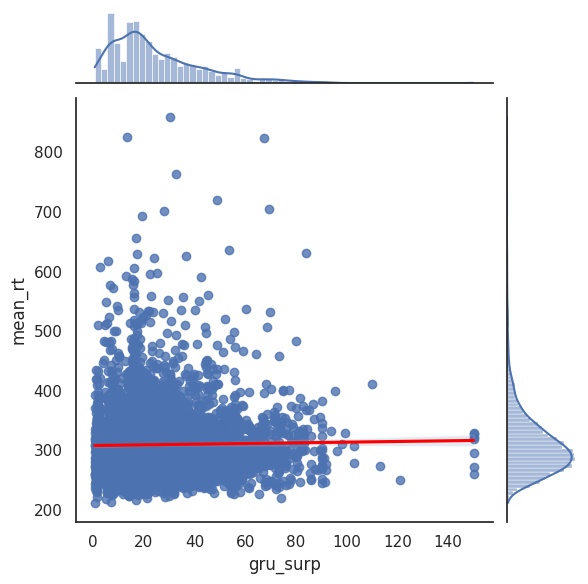

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="white", color_codes=True)

g = sns.jointplot(x="gru_surp", y="mean_rt", data=merged, kind='reg')
# We're going to make the regression line red so it's easier to see
regline = g.ax_joint.get_lines()[0]
regline.set_color('red')

In [ ]:
mse = mean_squared_error(y, gam.predict(X), squared=False)
print("The root mean squared error (RMSE) of GAM: {:.4f}".format(mse))

The root mean squared error (RMSE) of GAM: 52.8069


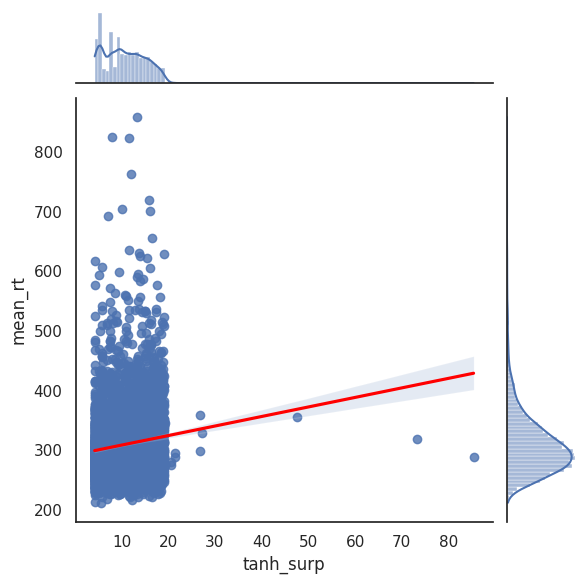

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="white", color_codes=True)

g = sns.jointplot(x="tanh_surp", y="mean_rt", data=merged, kind='reg')
# We're going to make the regression line red so it's easier to see
regline = g.ax_joint.get_lines()[0]
regline.set_color('red')

In [ ]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      27.335
Link Function:                     IdentityLink Log Likelihood:                                -48715.6002
Number of Samples:                         5500 AIC:                                            97487.8705
                                                AICc:                                           97488.1744
                                                GCV:                                             2827.7819
                                                Scale:                                           2802.4958
                                                Pseudo R-Squared:                                   0.0727
Feature Function                  Lam

<ipython-input-131-dec6a6acdaaa>:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


### Comparing Models

/usr/local/lib/python3.10/dist-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


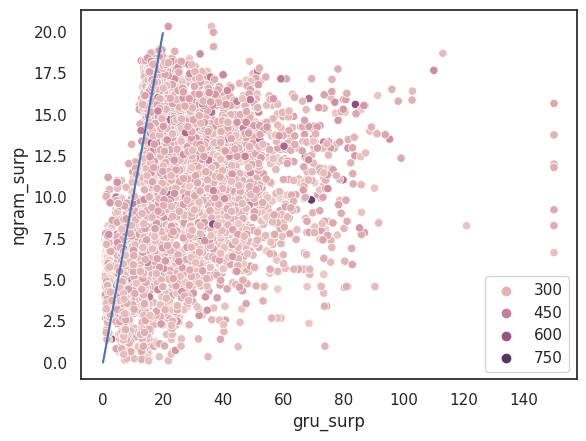

In [ ]:
import seaborn as sns

sns.scatterplot(data=merged, x='gru_surp', y='ngram_surp', hue='mean_rt', cmap='RdBu')
sns.lineplot(x=np.arange(0, 20, 0.1), y=np.arange(0, 20, 0.1))
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


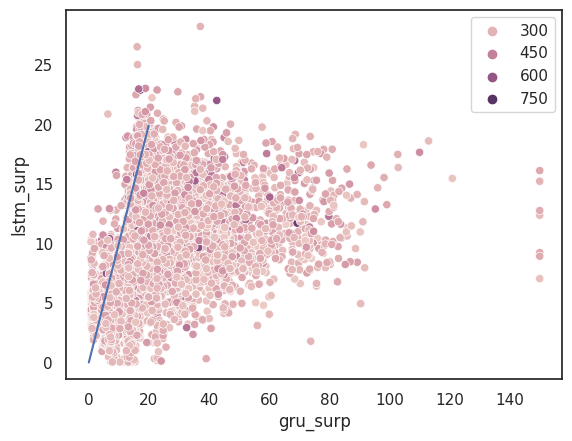

In [ ]:
import seaborn as sns

sns.scatterplot(data=merged, x='gru_surp', y='lstm_surp', hue='mean_rt', cmap='RdBu')
sns.lineplot(x=np.arange(0, 20, 0.1), y=np.arange(0, 20, 0.1))
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


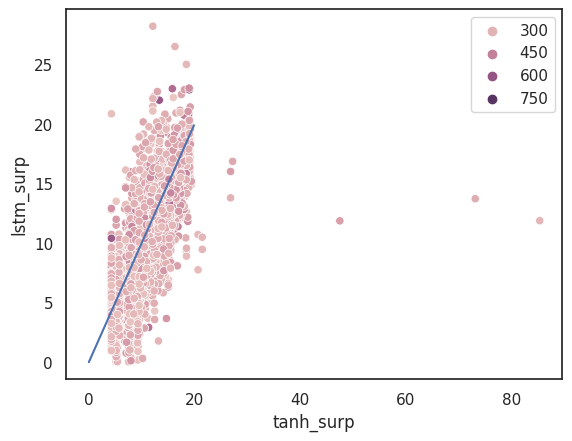

In [ ]:
import seaborn as sns

sns.scatterplot(data=merged, x='tanh_surp', y='lstm_surp', hue='mean_rt', cmap='RdBu')
sns.lineplot(x=np.arange(0, 20, 0.1), y=np.arange(0, 20, 0.1))
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


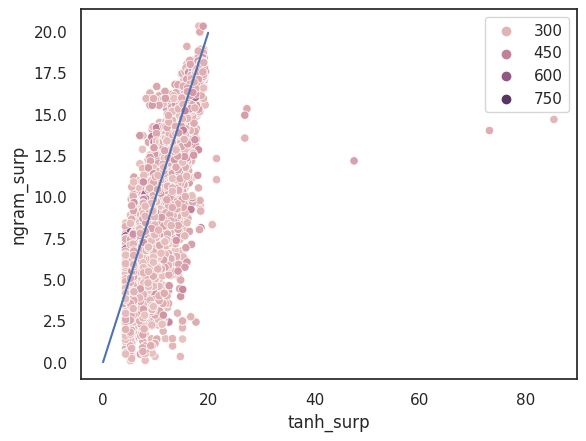

In [ ]:
import seaborn as sns

sns.scatterplot(data=merged, x='tanh_surp', y='ngram_surp', hue='mean_rt', cmap='RdBu')
sns.lineplot(x=np.arange(0, 20, 0.1), y=np.arange(0, 20, 0.1))
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


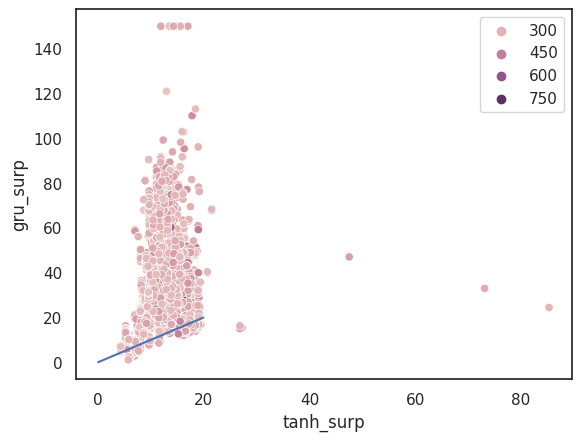

In [ ]:
import seaborn as sns

sns.scatterplot(data=merged, x='tanh_surp', y='gru_surp', hue='mean_rt', cmap='RdBu')
sns.lineplot(x=np.arange(0, 20, 0.1), y=np.arange(0, 20, 0.1))
plt.show()

In [ ]:
merged[[c for c in merged.columns if 'surp' in c]].corr()

,lstm_surp,ngram_surp,gru_surp,tanh_surp
lstm_surp,1.000000,0.894903,0.322724,0.812256
ngram_surp,0.894903,1.000000,0.262030,0.803946
gru_surp,0.322724,0.262030,1.000000,0.376156
tanh_surp,0.812256,0.803946,0.376156,1.000000


In [ ]:
# Importing library
import scipy.stats as stats

# Performing the paired sample t-test
stats.ttest_rel(merged['ngram_surp'], merged['lstm_surp'])

TtestResult(statistic=2.0651807945691307, pvalue=0.0389526569791973, df=5499)

In [ ]:
stats.ttest_rel(merged['tanh_surp'], merged['lstm_surp'])

TtestResult(statistic=33.16343623204005, pvalue=5.1189231959158125e-220, df=5499)

In [ ]:
stats.ttest_rel(merged['tanh_surp'], merged['ngram_surp'])

TtestResult(statistic=31.753624372817004, pvalue=2.5241217699360176e-203, df=5499)

In [ ]:
stats.ttest_rel(merged['gru_surp'], merged['lstm_surp'])

TtestResult(statistic=65.75187395880401, pvalue=0.0, df=5499)

In [ ]:
stats.ttest_rel(merged['gru_surp'], merged['ngram_surp'])

TtestResult(statistic=64.38968514652267, pvalue=0.0, df=5499)

In [ ]:
stats.ttest_rel(merged['gru_surp'], merged['tanh_surp'])

TtestResult(statistic=61.206213774167885, pvalue=0.0, df=5499)

In [ ]:
data['mean_surp'] = data[['lstm_surp', 'ngram_surp', 'gru_surp', 'tanh_surp']].mean(axis=1)

/usr/local/lib/python3.10/dist-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y /= div
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  NumPy method kept for backwards compatibility.


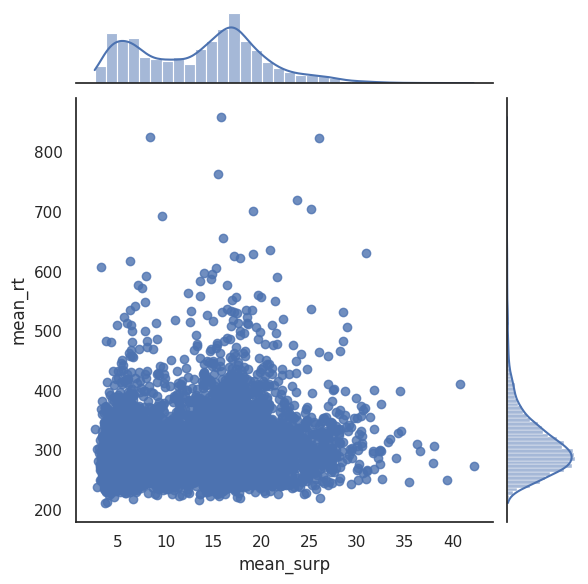

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="white", color_codes=True)

g = sns.jointplot(x="mean_surp", y="mean_rt", data=data, kind='reg')
# We're going to make the regression line red so it's easier to see
regline = g.ax_joint.get_lines()[0]
regline.set_color('red')